# Critic Pretraining

This notebook serves to demostrate how to pretrain the critic (from some source of generated data).

## TODO
1. LOTS

# Imports/Setup

In [1]:
from Data import critic_dataset
from Data import utility as data_utility
from Model import critics
from Model import utility as model_utility
from Evaluation import utility as eval_utility
from Objectives import losses, reward
import torch

# Configuration

In [2]:
class Config:
    # device
    device_pref = 'cuda'
    ind_dev = 3
    
    # dataset
    directory = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Buffer'
    cache = False
    seed = 42
    ratio = 0.8
    shuffle = True
    workers = 16
    pin = False
    postprocess = critic_dataset.postprocess
    
    # model
    n = 25
    down = 256 # if this is change, model architecture should be changed as well
    batch_size = 32
    sigmoid = False
    
    # training 
    epoches = 50
    lr = 1e-5
    mat_size = 25
    batch_size = 32
    verbose = False
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/critic_sigmoid_smaller.pth'

# Device

In [3]:
device = data_utility.set_device(Config.device_pref, Config.ind_dev)

Now using GPU.


# Critics Dataset

Instantiate the saved files during hyperparameter tuning to a torch dataset. Caching and dataloading is recommended for full data read in speed.

In [4]:
files = model_utility.get_torch_files(Config.directory)

In [5]:
split_params = {
    'files': files, 
    'train_ratio': Config.ratio, 
    'random_seed': Config.seed
}

train, valid = data_utility.train_valid_split(**split_params)

Total files: 50623
Training files: 40498 (80.0%)
Validation files: 10125 (20.0%)


In [6]:
train_dset_params = {
    'files': train, 
    'cache': Config.cache, 
    'root_dir': Config.directory                     
}
valid_dset_params = {
    'files': valid, 
    'cache': Config.cache, 
    'root_dir': Config.directory                     
}

t_dataset = critic_dataset.CriticDataset(**train_dset_params)
v_dataset = critic_dataset.CriticDataset(**valid_dset_params)

In [7]:
train_dl_params = {
    'dataset': t_dataset, 
    'batch_size': 1, 
    'shuffle': Config.shuffle, 
    'num_workers': Config.workers, 
    'pin_memory': Config.pin
}
valid_dl_params = {
    'dataset': v_dataset, 
    'batch_size': 1, 
    'shuffle': Config.shuffle, 
    'num_workers': Config.workers, 
    'pin_memory': Config.pin
}

train_dl = critic_dataset.get_dataloader(**train_dl_params)
valid_dl = critic_dataset.get_dataloader(**valid_dl_params)

# Model

Create the model for the critic. Two models are accessible: single output critc and multi ouput critic. The single and multi refer to how the output the measures of reward (combined versus seperate). Each variant requires a differnt `step` and `loss`.

In [8]:
model_params = {
    'n': Config.n, 
    'down': Config.down, 
    'batch_size': Config.batch_size, 
    'sigmoid_scale': Config.sigmoid
}

critic = critics.SmallerSingleCritic(**model_params).to(device)

## Reward/Loss

...

In [9]:
reward_func = reward.batched_reward(25, False, False)

In [10]:
criterion = losses.CriticSingleRewardLoss(1, 1, 1, reward_func)

## Training

...

In [11]:
def step(batch, model, criterion, device, size, batch_size):
    A, M, b = critic_dataset.postprocess(*batch)
    A, M, b = A.to(device).float(), M.to(device).float(), b.to(device).float()
    inp = torch.concat([A.view(batch_size, size**2), M.view(batch_size, size**2)], dim=1)
    
    out = model(inp)
    
    loss = criterion(out, A, M, b)
    return loss

training_params = {
    'epoches': Config.epoches,
    'criterion': criterion,
    'step': step,
    'train_loader': train_dl,
    'valid_loader': valid_dl,
    'model': critic,
    'lr': Config.lr,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'verbose': Config.verbose,
    'file_path': Config.file_path,
    'accumulation_steps': 1
}

In [ ]:
train_log, valid_log = model_utility.shared_training_loop(**training_params)

Epoch: 0, Train: 0.18004600376226232, Valid: 0.13676606078111683
Epoch: 1, Train: 0.11468232889654718, Valid: 0.08936709128249218
Epoch: 2, Train: 0.08310423778627347, Valid: 0.07972785437407251
Epoch: 3, Train: 0.06964390026778397, Valid: 0.07227596155249616
Epoch: 4, Train: 0.061133413352334624, Valid: 0.061339983988434356
Epoch: 5, Train: 0.05507215980948565, Valid: 0.07287785783467274
Epoch: 6, Train: 0.05053653260501083, Valid: 0.04485292739160057


In [15]:
plot_training_params = {
    'train_log': train_log,
    'valid_log': valid_log,
    'title': 'EX_t', 
    'file_path': 'plt.png'
}

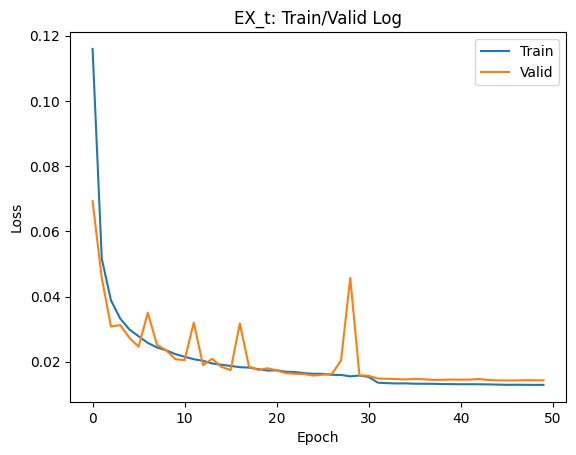

In [16]:
eval_utility.plot_training(**plot_training_params)

In [17]:
import matplotlib.pyplot as plt

In [24]:
A, M, b = critic_dataset.postprocess(*next(iter(valid_dl)))
A, M, b = A.to(device).float(), M.to(device).float(), b.to(device).float()
inp = torch.concat([A.view(32, 25**2), M.view(32, 25**2)], dim=1)

critic(inp)

tensor([[8.0978e-01, 1.4170e-09, 1.9199e-01],
        [7.9083e-01, 7.8184e-10, 1.7426e-01],
        [8.0756e-01, 4.8500e-10, 1.7904e-01],
        [8.1216e-01, 7.2386e-10, 1.8524e-01],
        [7.9105e-01, 1.7841e-09, 1.8948e-01],
        [8.2773e-01, 3.6985e-10, 1.7723e-01],
        [8.0371e-01, 4.9738e-10, 1.7536e-01],
        [8.0256e-01, 5.7855e-10, 1.8196e-01],
        [8.1078e-01, 6.8540e-10, 1.8361e-01],
        [8.0485e-01, 1.4135e-09, 1.9071e-01],
        [7.9910e-01, 1.0856e-09, 1.8180e-01],
        [8.0520e-01, 5.8086e-10, 1.7397e-01],
        [8.0051e-01, 1.1172e-09, 1.8304e-01],
        [8.0945e-01, 4.0418e-10, 1.7651e-01],
        [8.0916e-01, 1.1247e-09, 1.8558e-01],
        [8.1054e-01, 5.7276e-10, 1.8149e-01],
        [7.6420e-01, 1.4753e-09, 1.8467e-01],
        [8.0803e-01, 6.6368e-10, 1.7513e-01],
        [8.1985e-01, 5.7863e-10, 1.7822e-01],
        [8.0645e-01, 9.2648e-10, 1.8101e-01],
        [8.1310e-01, 9.0101e-10, 1.8656e-01],
        [8.0602e-01, 6.9166e-10, 1

In [25]:
import torch
from torch_cg.torch_cg import cg_batch

# Compute the the ground truth for the batched reward
class batched_reward():
    def __init__(self, size, verbose):
        self.size = size
        self.verbose = verbose
    
    def forward(self, A, M, b):
        _, info = cg_batch(
            lambda x: torch.matmul(A, x), b,                   
            lambda x: torch.matmul(M, x), 
            maxiter=self.size, 
            verbose=self.verbose
        )
        niter, optimal, last_residual = info['niter'], info['optimal'], info['last_residual']
        
        sparse_v = 1 - (torch.count_nonzero(M, dim=(1, 2)) / (self.size**2)) # 1 - (non / total) = % of zero
        iters_v = 0 if not optimal else 1/niter
        res_v = 1/(1+last_residual)
                
        return sparse_v, iters_v, res_v
    
b_reward = batched_reward(25, False)
b_reward.forward(A, M, b)

(tensor([0.8272, 0.8320, 0.8288, 0.8352, 0.8240, 0.8128, 0.8256, 0.8528, 0.8352,
         0.8416, 0.8320, 0.8352, 0.8192, 0.8512, 0.8176, 0.8224, 0.7968, 0.8288,
         0.8160, 0.8064, 0.8416, 0.8384, 0.8048, 0.8112, 0.8288, 0.8112, 0.8256,
         0.8320, 0.8176, 0.8256, 0.8304, 0.8576], device='cuda:3'),
 0,
 tensor([[0.0226],
         [0.0856],
         [0.6927],
         [0.0408],
         [0.0734],
         [0.3656],
         [0.0411],
         [0.3784],
         [0.1197],
         [0.0329],
         [0.0300],
         [0.1401],
         [0.0678],
         [0.0347],
         [0.0707],
         [0.3364],
         [0.0680],
         [0.3430],
         [0.2099],
         [0.1983],
         [0.0384],
         [0.4446],
         [0.2311],
         [0.0574],
         [0.2361],
         [0.0559],
         [0.6306],
         [0.0741],
         [0.0779],
         [0.5249],
         [0.0441],
         [0.1048]], device='cuda:3'))

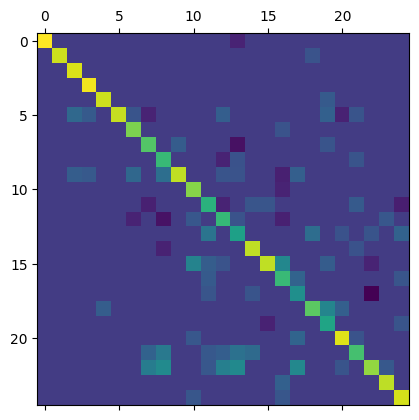

In [26]:
plt.matshow(M[0].cpu())